In [3]:
import xarray as xr
import numpy as np
import networkx as nx

import warnings
warnings.filterwarnings('ignore')
from load_data import get_data

In [4]:
data = get_data()
data

<xarray.Dataset>
Dimensions:  (lon: 64, level: 13, lat: 32, time: 116880)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T21:00:00
Data variables:
    z        (time, level, lat, lon) float32 dask.array<chunksize=(112, 13, 32, 64), meta=np.ndarray>
    t        (time, level, lat, lon) float32 dask.array<chunksize=(112, 13, 32, 64), meta=np.ndarray>
    q        (time, level, lat, lon) float32 dask.array<chunksize=(112, 13, 32, 64), meta=np.ndarray>
    u        (time, level, lat, lon) float32 dask.array<chunksize=(112, 13, 32, 64), meta=np.ndarray>
    v        (time, level, lat, lon) float32 dask.array<chunksize=(112, 13, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-02 22:48:04 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [5]:
R = 6371
mean_lon = np.mean(data.coords['lon'].values)
mean_lat = np.mean(data.coords['lon'].values)
coords = []
all_points = []
for lat in data.coords['lat'].values:
    for lon in data.coords['lon'].values:
        all_points.append((lat,lon))
        # all_points.append((lon, lat))
all_points = np.array(all_points)

In [7]:
import pyproj
def pyproj_xyz(lat, lon, R):
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    
    return pyproj.transform(lla, ecef, lon, lat, R)


def pyproj_coords(x, y, z):
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    
    lon, lat, r =  pyproj.transform(ecef, lla, x, y, z,)
    return lat, lon, r

In [8]:
cart_points = []
for point in all_points:
    cart_points.append(pyproj_xyz(point[0], point[1], R))
cart_points = np.array(cart_points)

In [9]:
def convert_to_coords(x,y,z):
    p = pyproj_coords(x,y,z)
    return (np.round(p[0], 4), np.round((p[1] + 360) % 360, 4))

In [10]:
converted_back = []
for c_p in cart_points:
    converted_back.append(convert_to_coords(*c_p))

In [13]:
def check_existance_of_neighbours(neighbours, all_nodes):
    _neighbours = np.empty(len(neighbours), dtype=object)
    _neighbours[:] = neighbours
    
    _all_nodes = np.empty(len(all_nodes), dtype=object)
    _all_nodes[:] = all_nodes
    evaluation = [neigh in list(_all_nodes) for neigh in _neighbours]
    return np.all(evaluation) 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

nodes_as_tuples = [tuple(p) for p in all_points]
for pt in converted_back:
    if not check_existance_of_neighbours([pt], nodes_as_tuples):
        # raise Exception(f"{pt}: \n doesnt exist among nodes")
        print(f"Point {pt} isnt among nodes, trying to get nearest {find_nearest(np.array(nodes_as_tuples)[:, 0], pt[0])}, {find_nearest(np.array(nodes_as_tuples)[:, 1], pt[1])}")

In [51]:
from sklearn.neighbors import NearestNeighbors
def find_neightbours(cart_points, order=1):
    orig_kernel = 3
    kernel = orig_kernel + ((order) * 2)
    neighbourhood_size = kernel ** 2
    print(f"building neighbourhood of size {neighbourhood_size}")
    knn = NearestNeighbors(n_neighbors=neighbourhood_size, algorithm='brute')
    knn.fit(cart_points)
    return knn.kneighbors(cart_points)

def filter_adj_order(high_order_neighbours, lower_order_neighbours, keep_every_nth_node=1):
    print(f'keep_every_nth_node: {keep_every_nth_node}')
    nearest_neighbours_higher_order = []
    for i in range(high_order_neighbours[1].shape[0]):
        furthest_node_indices = np.argpartition(high_order_neighbours[0][i], -8)[-8:]
        indices = np.append(furthest_node_indices, 0)
        # remaining = [idx == i or idx not in lower_order_neighbours[1][i] for idx in high_order_neighbours[1][i]]
        # filtered_nodes = list(sorted(high_order_neighbours[1][i][remaining]))
        remaining_nodes = list(sorted(high_order_neighbours[1][i][indices]))
        # remaining_nodes= []
        # for j, node in enumerate(filtered_nodes):
        #     if keep_every_nth_node == 0:
        #         remaining_nodes.append(node)
        #     elif j % keep_every_nth_node == 0:
        #         remaining_nodes.append(node)
        
        
        if len(remaining_nodes) > 1:
            nearest_neighbours_higher_order.append(remaining_nodes)
    return nearest_neighbours_higher_order

def get_neighbourhood_for_n_orders(cart_points, n_orders=2):
    neighourhood_orders = []
    for i in range(0, n_orders):
        neighourhood_orders.append(find_neightbours(cart_points, order=i))
        
    high_to_low = list(reversed(neighourhood_orders))
    # high_to_low = neighourhood_orders
    neighbourhoods = []
    print(len(high_to_low), len(high_to_low[0][1][0]), len(high_to_low[1][1][0]))
    # for i in range(len(high_to_low), 0, -1):
    #     filtered_adj = filter_adj_order(high_to_low[i-1], high_to_low[i-2])
    for i in range(len(high_to_low)-1):
        filtered_adj = filter_adj_order(high_to_low[i], high_to_low[i+1], keep_every_nth_node=len(high_to_low)-i-1)
        # filtered_adj = filter_adj_order(high_to_low[i], high_to_low[i+1])
        if len(filtered_adj) > 0:
            neighbourhoods.append(filtered_adj)
        
    return list(reversed(neighbourhoods))

In [53]:
nbs = get_neighbourhood_for_n_orders(cart_points, 2)

building neighbourhood of size 9
building neighbourhood of size 25
2 25 9
keep_every_nth_node: 1


In [29]:
tuple_cart_points = [tuple(p) for p in cart_points]

In [30]:
_points_cart = np.empty(len(tuple_cart_points), dtype=object)
_points_cart[:] = tuple_cart_points

In [57]:
from geopy import distance
from torch_geometric.utils.convert import from_networkx
import pickle

def get_adj_graphs(neighbourhoods):
    sphere_graphs = []
    for j, neighbourhood in enumerate(neighbourhoods):
        coord_edges = []
        coord_nodes = []
        for i in range(len(tuple_cart_points)):
            point = tuple_cart_points[i]
            # neighbours_indices = nearest_neighbours[1][i]
            # neighbours_indices = nearest_neighbours_order_2[i]
            neighbours_indices = neighbourhood[i]
            ngbs = _points_cart[neighbours_indices]
            coord_point = convert_to_coords(*point)
            
            # if i % 200 == 0:
            nb_coords = [convert_to_coords(*nb) for nb in ngbs]
            neighbours_distances = [distance.distance(coord_point, nb).meters for nb in nb_coords]
            edges_coord = [(coord_point, neighbour, {'distance': distnc}) for neighbour, distnc in zip(nb_coords, neighbours_distances)]
            coord_edges.append(edges_coord)
            coord_nodes.append(coord_point)    
            
            
        sphere_graph = nx.Graph()
        sphere_graph.add_nodes_from(coord_nodes)
        for edge in coord_edges:
            sphere_graph.add_edges_from(edge)
            
        # pickle.dump(sphere_graph, open('./sphere_graph.pickle', 'wb'))
        # pickle.dump(sphere_graph, open(f'./sphere_graph_adj_radius_{j+2}.pickle', 'wb'))
        
        # return sphere_graph
        sphere_graphs.append(sphere_graph)
        
    return sphere_graphs
            
        

In [55]:
sphere_graphs = get_adj_graphs(nbs)

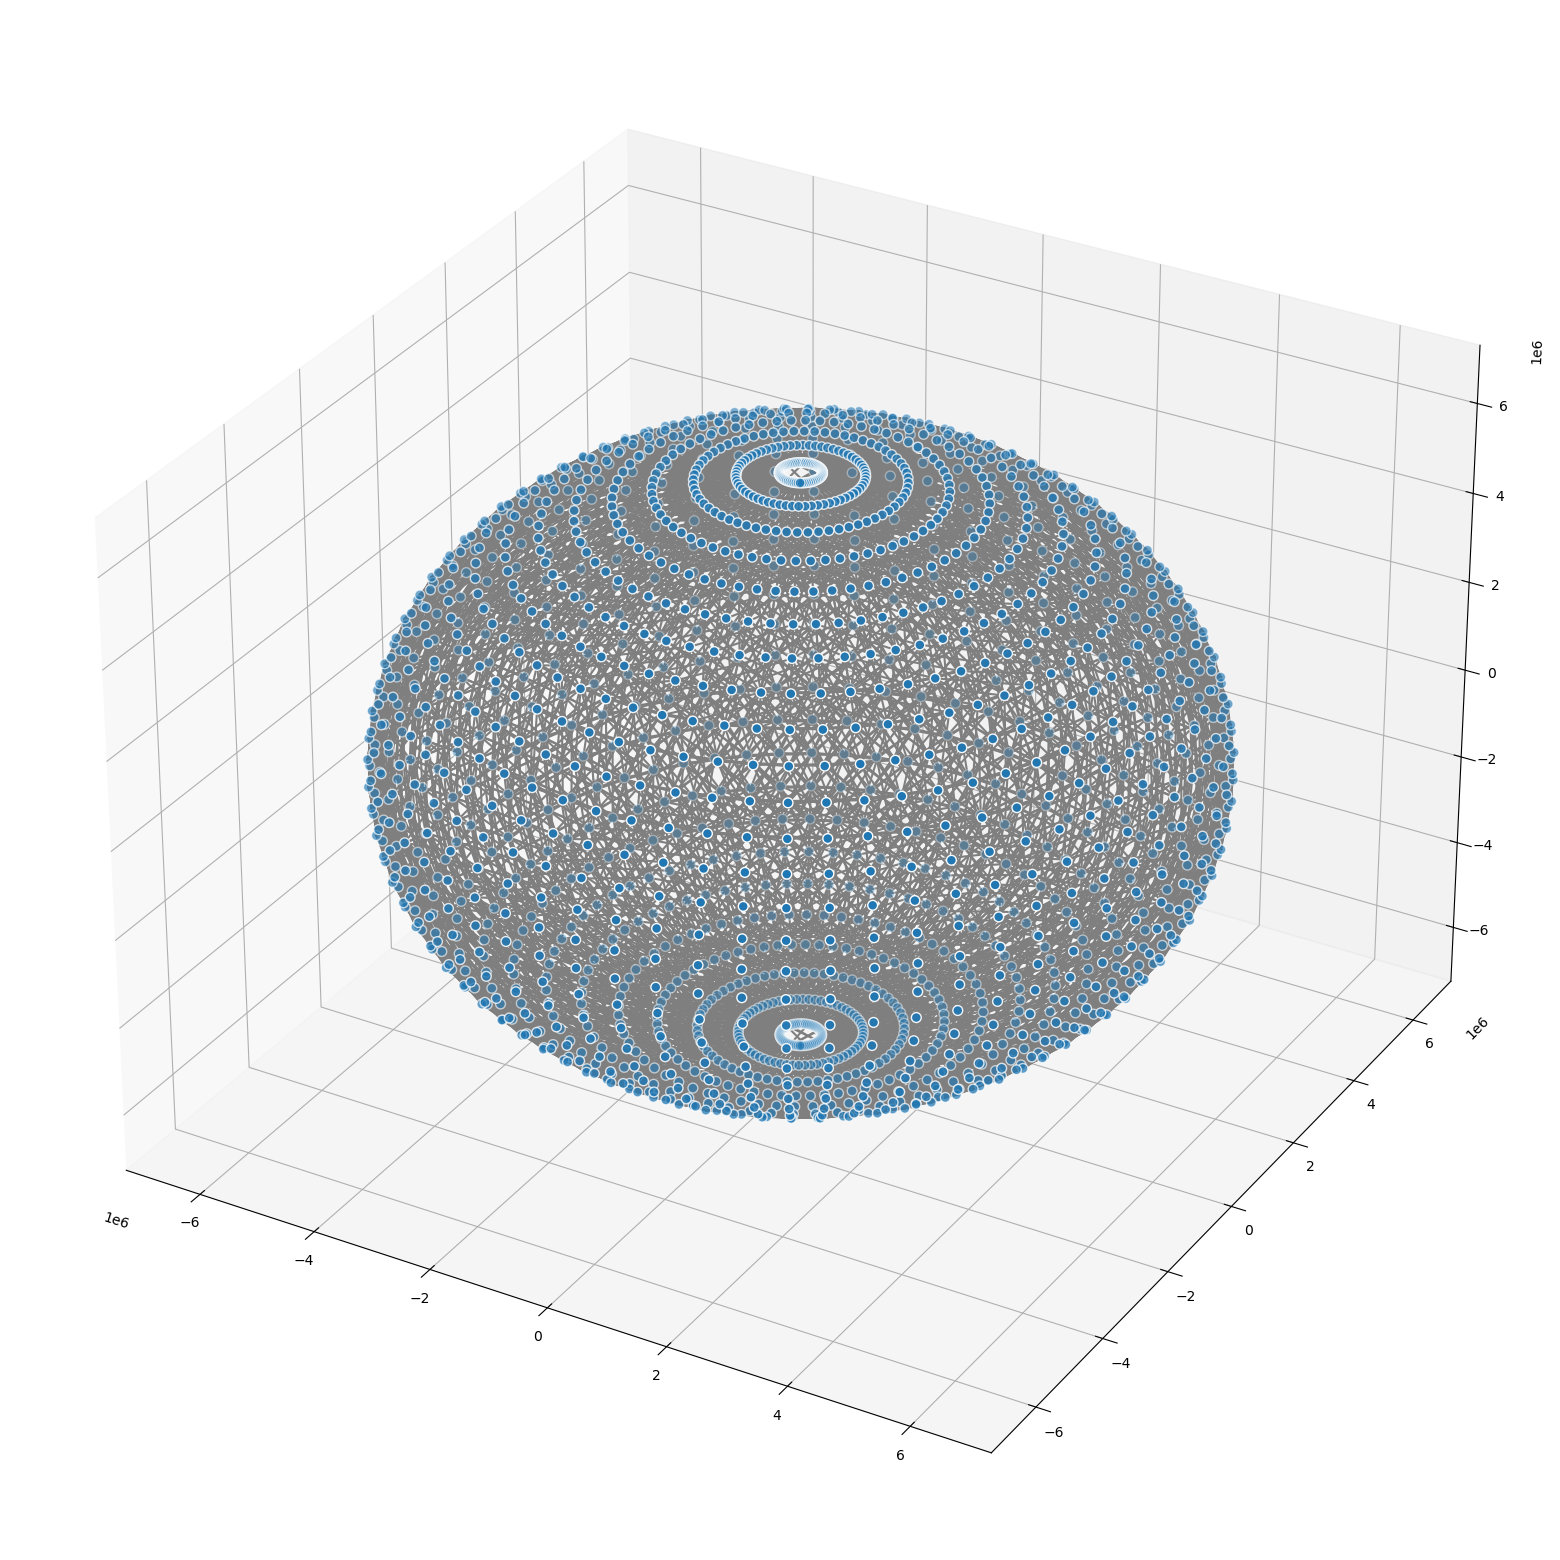

In [56]:
import matplotlib.pyplot as plt
# need sphere_graph
sphere_graph = sphere_graphs[0]
node_xyz = np.array([pyproj_xyz(*v, R) for v in sphere_graph])
sphere_edge = np.array([(pyproj_xyz(*u, R), pyproj_xyz(*v, R)) for u,v in sphere_graph.edges()])

fig2 = plt.figure(figsize=(20, 20))
ax2 = fig2.add_subplot(projection='3d')

ax2.scatter(*node_xyz.T, s=50, ec="w")
for vizedge in sphere_edge:
    ax2.plot(*vizedge.T, color="tab:gray")

In [75]:
import pickle

# pickle.dump(sphere_graph, open('./sphere_graph.pickle', 'wb'))
pickle.dump(sphere_graph, open('./sphere_graph_dilated.pickle', 'wb'))